PROBLEM: by including pre-2007 evictions, i'm no longer looking at evictions per unit per year bc there are no pre-2007 zero-eviction records. Pre-2007 records only appear if there is an eviction when we use a post-2007 asessor record to stand in for a pre-2007 property.

In [17]:
asr['pre_07_ev'] = asr['ev_count'] - asr['ev_count_post_07']

In [18]:
asr.groupby('asr_yr')['pre_07_ev'].sum()

asr_yr
2007    22627
2008      106
2009      105
2010      159
2011       61
2012       16
2013      166
2014      156
2015      133
2016      109
2017        0
Name: pre_07_ev, dtype: int64

<AxesSubplot:>

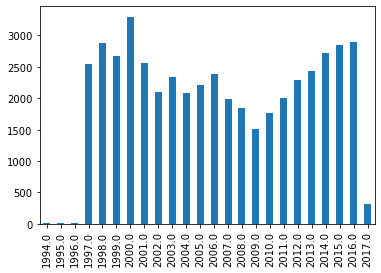

In [81]:
evictions['year'].value_counts(sort=False).plot(kind='bar')

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [80]:
evictions = pd.read_csv('../data/ev_matched_w_fips.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Check aggregation

In [18]:
evictions_07 = evictions[evictions['year'] > 2006]

In [21]:
asr_evic = pd.merge(asr, evictions, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))
asr_evic_07 = pd.merge(asr, evictions_07, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))

In [22]:
check_df = asr_evic.groupby('asr_index').agg({'index_evic':'count', 'ev_count':'min'})
check_df['all_evic_count'] = check_df['index_evic'] == check_df['ev_count']

In [23]:
check_df['all_evic_count'].all()

True

In [24]:
check_df_07 = asr_evic_07.groupby('asr_index').agg({'index_evic':'count', 'ev_count_post_07':'min'})
check_df_07['all_evic_count'] = check_df_07['index_evic'] == check_df_07['ev_count_post_07']

In [25]:
check_df_07['all_evic_count'].all()

True

### Main

In [64]:
asr = pd.read_csv('../data/asr_grouped_by_yr_w_fips.csv')

In [66]:
evictions = evictions[(evictions['year'] > 2009) & (evictions['year'] < 2017)]  # for per-year accuracy
evictions_from_14 = evictions[evictions['year'] > 2013]  #14,15,16
evictions_to_13 = evictions[evictions['year'] < 2013]  # 10,11,12

In [69]:
asr_evic_from_14 = pd.merge(asr, evictions_from_14, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))
asr_evic_to_13 = pd.merge(asr, evictions_to_13, left_on='index', right_on='asr_index', how='left', suffixes=('_asr','_evic'))

In [70]:
asr_evic_from_14 = asr_evic_from_14[((asr_evic_from_14['asr_yr'] > 2013) & ((asr_evic_from_14['asr_yr'] < 2017))) | (asr_evic_from_14['asr_index'].notnull())]

In [71]:
asr_evic_from_14['asr_yr'].value_counts()

2016    159553
2015    158935
2014    158291
2010        16
2007        10
2012         9
2013         2
2008         2
Name: asr_yr, dtype: int64

In [73]:
asr_evic_to_13 = asr_evic_to_13[((asr_evic_to_13['asr_yr'] < 2013) & ((asr_evic_to_13['asr_yr'] > 2009))) | (asr_evic_to_13['asr_index'].notnull())]

In [74]:
asr_evic_to_13['asr_yr'].value_counts()

2012    156859
2010    156416
2011    150039
2009       123
2016        32
2013        28
2015        16
2014         7
2008         4
2007         4
Name: asr_yr, dtype: int64

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

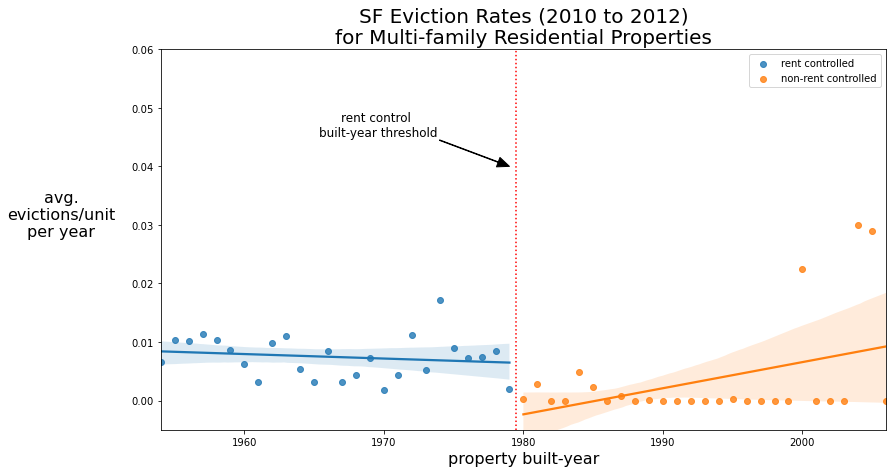

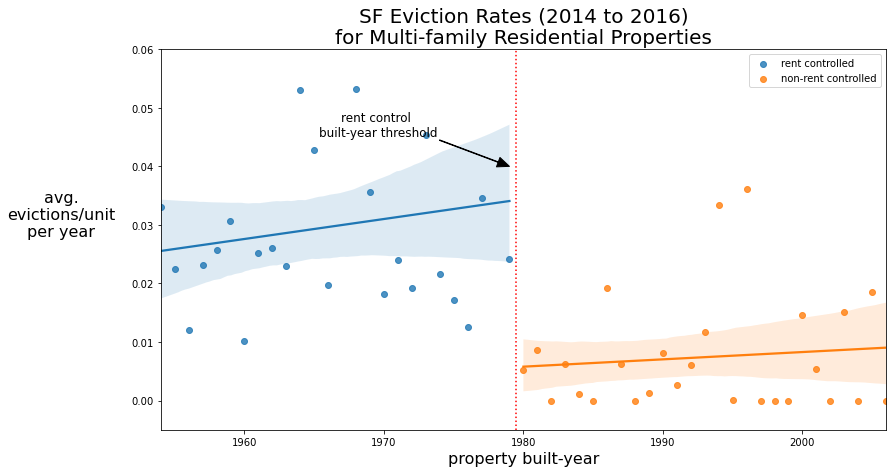

In [75]:
names = ['2010 to 2012', '2014 to 2016']
for i, asr in enumerate([asr_evic_to_13, asr_evic_from_14]):

    rc_pop = asr[
        (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1953) &
        (asr['year_built_max'] < 2007) & (asr['total_units'] > 0)]
    
    rc_pop_uniq = rc_pop.groupby('index_asr').agg(
        num_evics=('index_evic', 'count'), year_built_max=('year_built_max', 'min'), total_units=('total_units','max'))
    rc_pop_uniq['ev_per_unit'] = rc_pop_uniq['num_evics'] / rc_pop_uniq['total_units']

    yr_vs_ev = rc_pop_uniq.groupby('year_built_max').agg({
        'ev_per_unit': 'mean',
    }).reset_index()

    yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['year_built_max'] < 1980) &
                         (yr_vs_ev['year_built_max'] >= 1953)]
    yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['year_built_max'] >= 1980) &
                         (yr_vs_ev['year_built_max'] <= 2007)]
    fig, ax = plt.subplots(figsize=(13,7))
    sns.regplot('year_built_max', 'ev_per_unit', yr_vs_ev1, ax=ax, truncate=True, label='rent controlled')
    sns.regplot('year_built_max', 'ev_per_unit', yr_vs_ev2, ax=ax, truncate=True, label='non-rent controlled')
    ax.axvline(1979.5, ls=':', c='r')
    ax.legend()
    _ = ax.set_xlabel("property built-year", fontsize=16)
    _ = ax.set_ylabel("avg.\nevictions/unit\nper year", fontsize=16, rotation=0, labelpad=70)
    _ = ax.set_title("SF Eviction Rates ({0})\nfor Multi-family Residential Properties".format(names[i]), fontsize=20)
    ax.set_ylim((-0.005, 0.06))
    ax.annotate('rent control \nbuilt-year threshold', xy=(1979, 0.04),  xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction',
                arrowprops=dict(facecolor='black',frac=0.05, width=0.5, headwidth=10),
                horizontalalignment='center', verticalalignment='center', fontsize=12
                )

In [77]:
asr_evic_to_13['asr_index'].count()

5775

In [78]:
asr_evic_from_14['asr_index'].count()

8127